# Preprocessing Data 

In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from datetime import date
import datetime
from pandas._libs.tslibs.timestamps import Timestamp

In [3]:
data_path = '../../data/'
data = pd.read_csv('../../data/crypto_pairs_2020-10-22-total.csv')
data_7d_1 = pd.read_csv('../../data/crypto_pairs_7d_2020-10-29.csv')
data_7d_2 = pd.read_csv('../../data/crypto_pairs_7d_2020-11-05.csv')

# We define the list of tokens we want to use 
optim_env = ['BNT/ETH', 
            'SNT/ETH', 
            'ENJ/ETH', 
            'LEND/ETH', 
            'LRC/ETH',  
            'POWR/ETH']

In [4]:
data = data[data['symbol'].isin(optim_env)]
data_1 = data_7d_1[data_7d_1['symbol'].isin(optim_env)]
data_2 = data_7d_2[data_7d_2['symbol'].isin(optim_env)]

In [5]:
data_2.head(7)

,Unnamed: 0,timestamp,date,source,symbol,open,total_volume
70,70,1604016000000,2020-10-30,ccxt_binance,BNT/ETH,0.001622,250248.58
71,71,1604102400000,2020-10-31,ccxt_binance,BNT/ETH,0.001557,95393.97
72,72,1604188800000,2020-11-01,ccxt_binance,BNT/ETH,0.001529,30654.71
73,73,1604275200000,2020-11-02,ccxt_binance,BNT/ETH,0.001541,60193.04
74,74,1604361600000,2020-11-03,ccxt_binance,BNT/ETH,0.001555,36440.46
75,75,1604448000000,2020-11-04,ccxt_binance,BNT/ETH,0.001448,58764.43
76,76,1604534400000,2020-11-05,ccxt_binance,BNT/ETH,0.001331,24271.91


In [6]:
# LOADING AND PREPROCESSING DATA

today = pd.to_datetime(str(date.today()))
nb_days = 200
begin_date = today - datetime.timedelta(days=nb_days)


files = [f for f in listdir('../../data/') if isfile(join('../../data/', f))]
for i,file in enumerate(files[1:]):
    path = data_path + file
    if i == 0:
        data = pd.read_csv(path)
        data = data[data['symbol'].isin(optim_env)]
    else:
        data_add = pd.read_csv(path)
        data_add = data_add[data_add['symbol'].isin(optim_env)]
        data = pd.concat([data, data_add], axis=0)
        
data = data.reset_index().drop(columns=['Unnamed: 0', 'index'])  
data = data[pd.to_datetime(data['date'])>= begin_date]

In [7]:
# Transforming the dataframe into the good format
for i,symbol in enumerate(optim_env):
    if i == 0:
        data_optim = data[data['symbol'] == symbol][['date', 'open']]
        data_optim.columns = ['date', symbol]
    else: 
        data_to_add = data[data['symbol'] == symbol][['date', 'open']]
        data_to_add.columns = ['date', symbol]
        data_optim = pd.merge(data_to_add, data_optim, on='date', how='outer')

# sorting /removing duplicate dates / ffill and bfill for NaN values (axis=0 <--> for the same symbol)
data_optim = data_optim.sort_values(by='date').drop_duplicates(subset=['date']).ffill(axis=0).bfill(axis=0).set_index('date')

# add ETH/ETH pair
data_optim['ETH/ETH'] = 1.0

In [8]:
data_optim

,POWR/ETH,LRC/ETH,LEND/ETH,ENJ/ETH,SNT/ETH,BNT/ETH,ETH/ETH
date,,,,,,,
2020-06-10,0.000417,0.000368,0.000340,0.000827,0.000113,0.002977,1.0
2020-06-11,0.000438,0.000439,0.000384,0.000835,0.000117,0.003405,1.0
2020-06-12,0.000391,0.000374,0.000363,0.000806,0.000110,0.003270,1.0
2020-06-13,0.000406,0.000438,0.000406,0.000808,0.000111,0.003526,1.0
2020-06-14,0.000421,0.000429,0.000401,0.000801,0.000110,0.003500,1.0
...,...,...,...,...,...,...,...
2020-11-01,0.000202,0.000374,0.001346,0.000329,0.000055,0.001529,1.0
2020-11-02,0.000200,0.000376,0.001346,0.000320,0.000054,0.001541,1.0
2020-11-03,0.000196,0.000361,0.001346,0.000316,0.000052,0.001555,1.0


In [9]:
# MARKOWITZ OPTIMIZATION

window = 28 # Set the time window that will be used to compute expected return and asset correlations
rebalance_period = 14 # Set the number of days between each portfolio rebalancing
data = data_optim


def compute_markowitz_optim(window, rebalance_period, nportfolio, optim_env, data):
    nassets = len(optim_env) + 1 # Account for the ETH/ETH pair
    n = window
    prices = data
    pr = np.asmatrix(prices.values)
    t_prices = prices.iloc[1:n + 1]
    t_val = t_prices.values
    tminus_prices = prices.iloc[0:n]
    tminus_val = tminus_prices.values
    # Compute daily returns (r)
    r = np.asmatrix(t_val / tminus_val - 1)
    # Compute the expected returns of each asset with the average
    # daily return for the selected time window
    m = np.asmatrix(np.mean(r, axis=0))
    # ###
    stds = np.std(r, axis=0)
    # Compute excess returns matrix (xr)
    xr = r - m
    # Matrix algebra to get variance-covariance matrix
    cov_m = np.dot(np.transpose(xr), xr) / n
    # Compute asset correlation matrix (informative only)
    #corr_m = cov_m / np.dot(np.transpose(stds), stds)

    # Define portfolio optimization parameters
    n_portfolios = nportfolio
    results_array = np.zeros((3 + nassets, n_portfolios))
    for p in range(n_portfolios):
        weights = np.random.random(nassets)
        weights /= np.sum(weights)
        w = np.asmatrix(weights)
        p_r = np.sum(np.dot(w, np.transpose(m))) * 365
        p_std = np.sqrt(np.dot(np.dot(w, cov_m),
                               np.transpose(w))) * np.sqrt(365)

        # store results in results array
        results_array[0, p] = p_r
        results_array[1, p] = p_std
        # store Sharpe Ratio (return / volatility) - risk free rate element
        # excluded for simplicity
        results_array[2, p] = results_array[0, p] / results_array[1, p]

        for i, w in enumerate(weights):
            results_array[3 + i, p] = w

    columns = ['r', 'stdev', 'sharpe'] + optim_env + ['ETH/ETH']

    # convert results array to Pandas DataFrame
    results_frame = pd.DataFrame(np.transpose(results_array),
                                 columns=columns)
    # locate position of portfolio with highest Sharpe Ratio
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    # locate positon of portfolio with minimum standard deviation
    min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
    
    return results_frame, max_sharpe_port, min_vol_port

results_frame, max_sharpe_port, min_vol_port = compute_markowitz_optim(window = 28, 
                                                                        rebalance_period = 14,
                                                                        nportfolio = 50000,
                                                                        optim_env = optim_env,
                                                                        data = data_optim)

In [11]:
max_sharpe_port.to_csv('./max_sharpe_port.csv', header=None)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


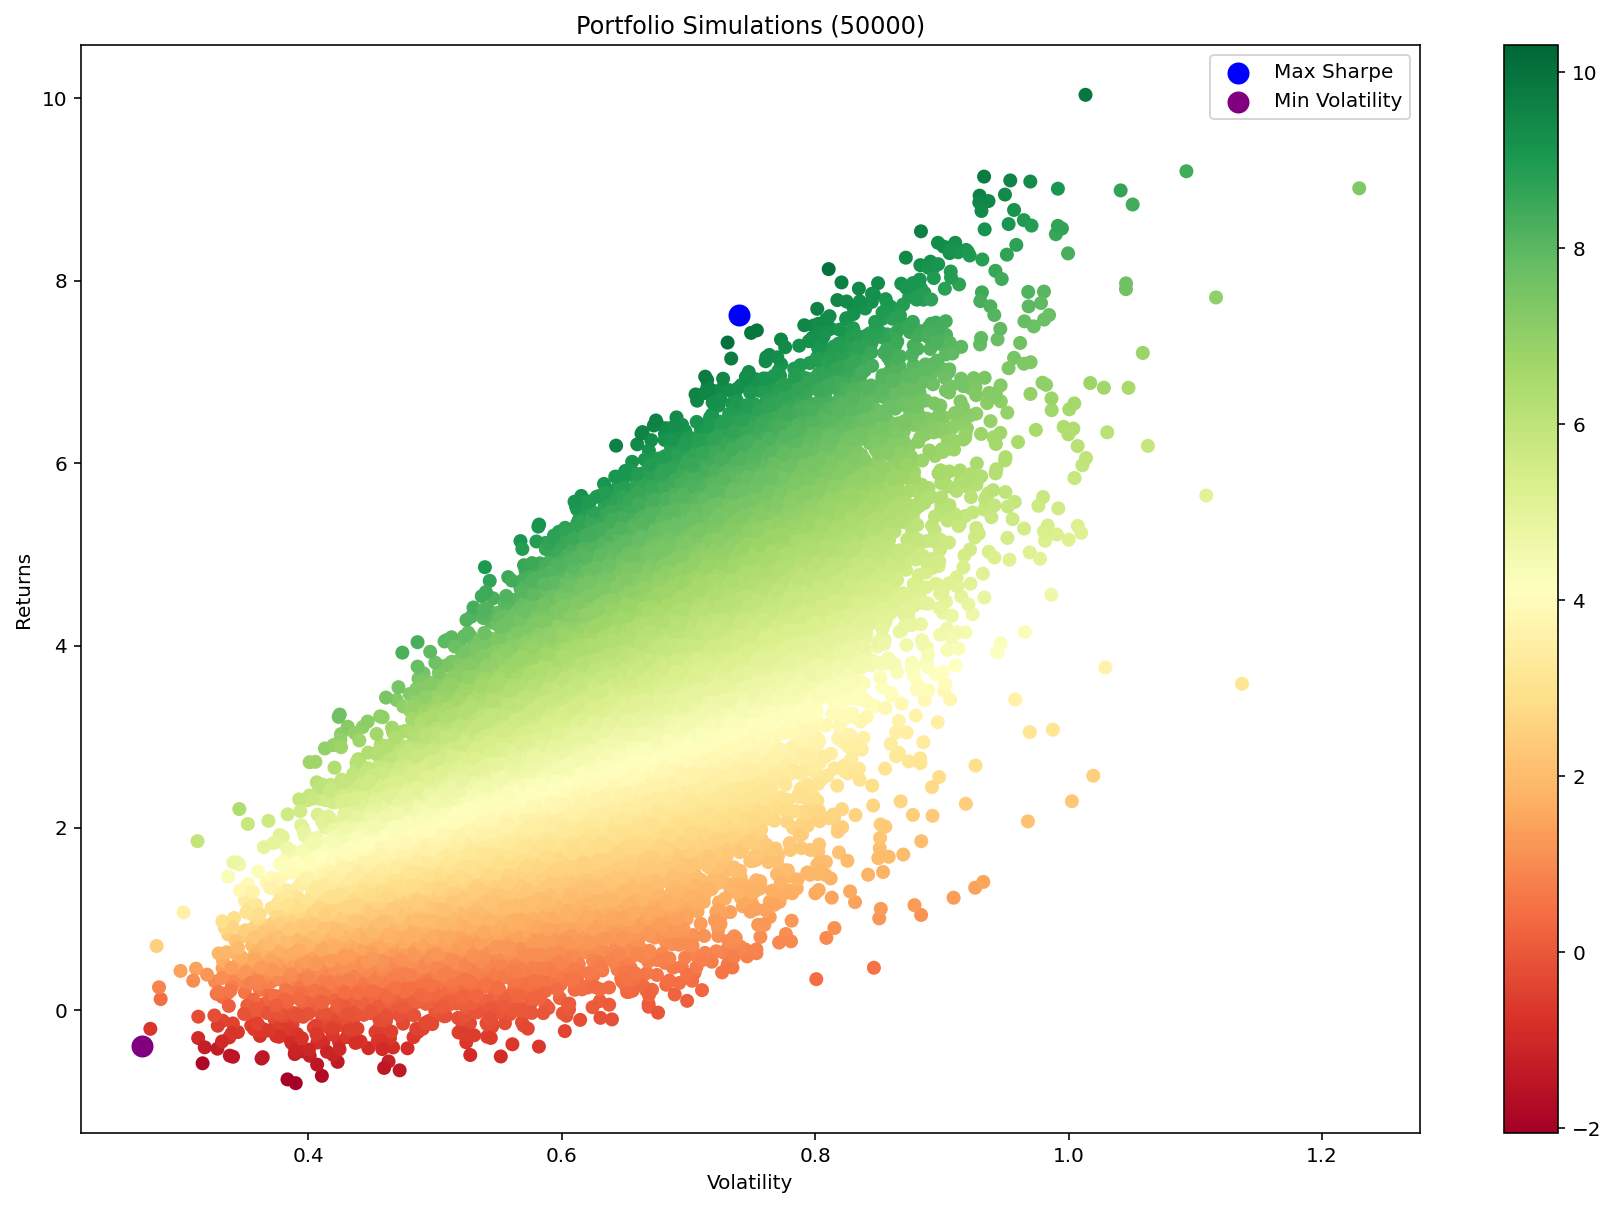

In [14]:
def plot_portfolio_simulation(results_frame, max_sharpe_port, min_vol_port):
    # create scatter plot coloured by Sharpe Ratio
    plt.scatter(results_frame.stdev,
                results_frame.r,
                c=results_frame.sharpe,
                cmap='RdYlGn')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.colorbar()

    # plot blue circle to highlight position of portfolio
    # with highest Sharpe Ratio
    plt.scatter(max_sharpe_port[1],
                max_sharpe_port[0],
                marker='o',
                color='b',
                s=100,
               label='Max Sharpe')
    
    # plot green circle to highlight position of portfolio
    # with lowest variance
    plt.scatter(min_vol_port[1],
                min_vol_port[0],
                marker='o',
                color='purple',
                s=100,
               label='Min Volatility')
    plt.legend()
    plt.title(f'Portfolio Simulations ({len(results_frame)})')

    return 

fig, ax = plt.subplots(1,1, figsize=(15,10))
plot_portfolio_simulation(results_frame, max_sharpe_port, min_vol_port)

In [15]:
min_vol_port

r          -0.395126
stdev       0.268769
sharpe     -1.470133
BNT/ETH     0.043650
SNT/ETH     0.002531
ENJ/ETH     0.016176
LEND/ETH    0.379244
LRC/ETH     0.106654
POWR/ETH    0.005677
ETH/ETH     0.446068
Name: 16157, dtype: float64